## Exercise 1

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg

# Filter design parameters
N = 81  # Number of taps (must be odd)
fs = 5000  # Sampling frequency
fc = 1250/2  # Cutoff frequency in Hz
fc_norm = fc / (fs / 2)  # Normalize cutoff to Nyquist (range: 0 to 1)

# Create the impulse response using the sinc function
n = np.arange(N)
center = (N - 1) / 2
h_ideal = np.sinc(2 * fc * (n - center) / fs)  # sinc argument in Hz


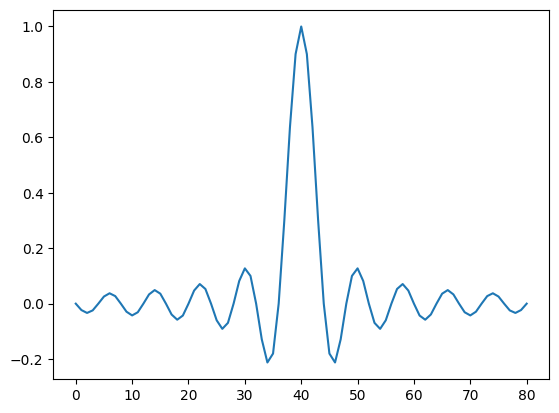

In [20]:
plt.plot(h_ideal)
plt.show()

In [21]:
# Generate Hamming window
hamming_win = sg.windows.hamming(N)

# Apply window to the ideal impulse response
h_fir = h_ideal * hamming_win


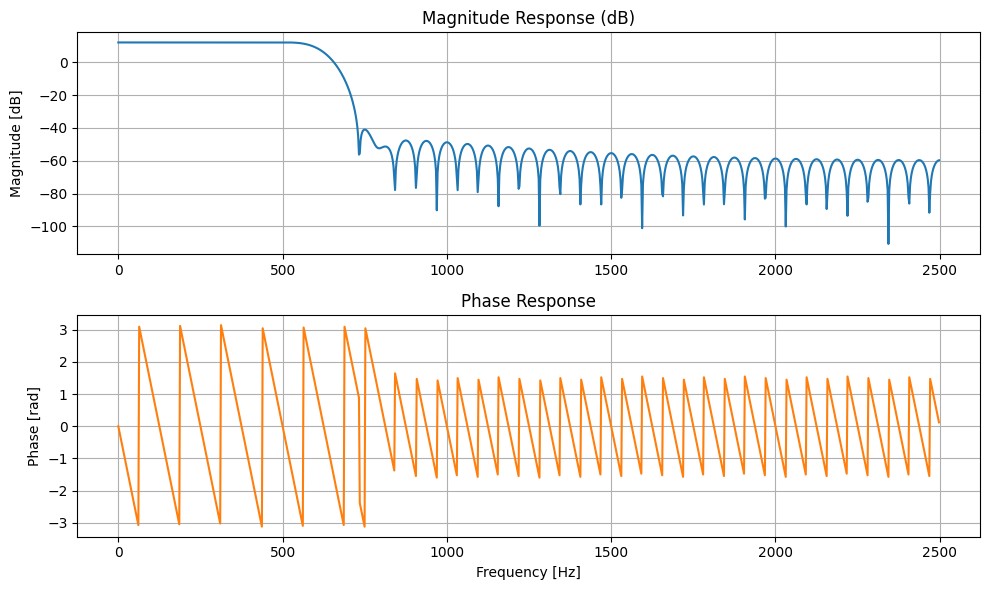

In [23]:
# Compute frequency response
w, H = sg.freqz(h_fir, worN=1024, fs=fs)

# Plot magnitude and phase
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(w, 20 * np.log10(np.abs(H)), color='C0')
plt.title("Magnitude Response (dB)")
plt.ylabel("Magnitude [dB]")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(w, np.angle(H), color='C1')
plt.title("Phase Response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [rad]")
plt.grid()

plt.tight_layout()
plt.show()


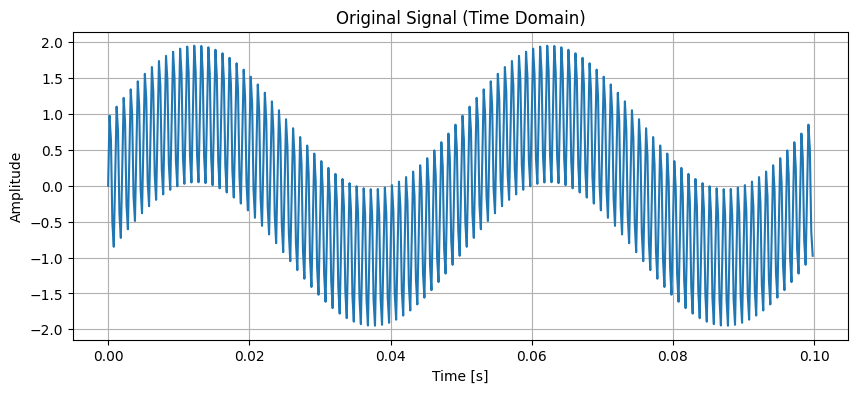

In [24]:
# Time vector
T = 1  # 1 second
t = np.linspace(0, T, int(fs * T), endpoint=False)

# Generate a signal with 20 Hz and 1000 Hz components
x = np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 1000 * t)

# Plot a portion of the signal
plt.figure(figsize=(10, 4))
plt.plot(t[:500], x[:500], color='C0')
plt.title("Original Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


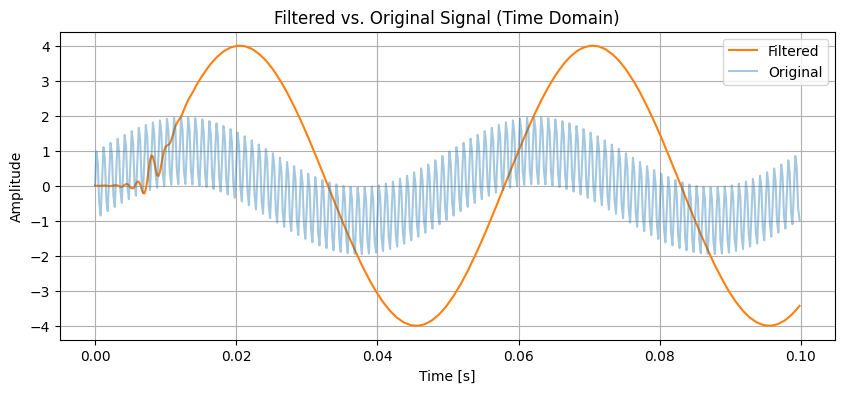

In [25]:
# Apply FIR filter
y = sg.lfilter(h_fir, 1.0, x)

# Plot filtered signal
plt.figure(figsize=(10, 4))
plt.plot(t[:500], y[:500], color='C1', label="Filtered")
plt.plot(t[:500], x[:500], color='C0', alpha=0.4, label="Original")
plt.title("Filtered vs. Original Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


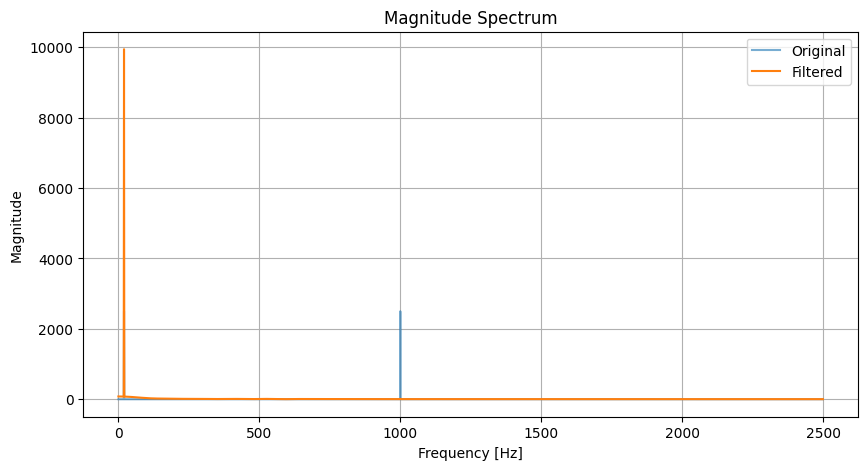

In [26]:
from scipy.fft import fft, fftfreq

# Compute FFTs
N_fft = len(x)
X = np.abs(fft(x))[:N_fft//2]
Y = np.abs(fft(y))[:N_fft//2]
freqs = fftfreq(N_fft, 1/fs)[:N_fft//2]

# Plot magnitude spectra
plt.figure(figsize=(10, 5))
plt.plot(freqs, X, label="Original", alpha=0.6)
plt.plot(freqs, Y, label="Filtered", color='C1')
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()


## Exercise 2

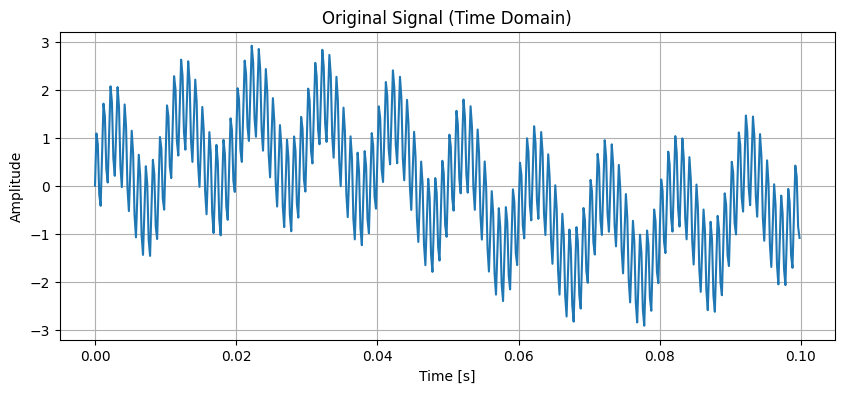

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy.fft import fft, fftfreq

# Sampling and time vector
fs = 5000  # Sampling frequency
T = 1      # Duration in seconds
t = np.linspace(0, T, int(fs * T), endpoint=False)

# Generate composite signal
x = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*100*t) + np.sin(2*np.pi*1000*t)

# Plot time-domain signal
plt.figure(figsize=(10, 4))
plt.plot(t[:500], x[:500])
plt.title("Original Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [28]:
def plot_filter_response(b, fs, label):
    w, h = sg.freqz(b, worN=1024, fs=fs)
    plt.plot(w, 20 * np.log10(np.abs(h)), label=label)


In [29]:
# Low-pass design parameters
ripple_db = 60
trans_width = 90 - 70  # Hz
width_norm = trans_width / (fs / 2)  # Normalized transition width

# Get taps and beta
N_lp, beta_lp = sg.kaiserord(ripple_db, width_norm)
N_lp |= 1  # Force odd number of taps

# Design filter
lp_cutoff = 70
b_lp = sg.firwin(N_lp, lp_cutoff, window=('kaiser', beta_lp), fs=fs)


In [30]:
# Band-pass: fl1 = 20, fh1 = 75, fl2 = 200, fh2 = 850
trans_width_bp = min(75 - 20, 850 - 200)
width_norm_bp = trans_width_bp / (fs / 2)

# Get taps and beta
N_bp, beta_bp = sg.kaiserord(ripple_db, width_norm_bp)
N_bp |= 1

# Design band-pass filter
bp_band = [75, 200]
b_bp = sg.firwin(N_bp, bp_band, pass_zero=False, window=('kaiser', beta_bp), fs=fs)


In [31]:
# High-pass: fl = 200, fh = 500
trans_width_hp = 200
width_norm_hp = trans_width_hp / (fs / 2)

# Get taps and beta
N_hp, beta_hp = sg.kaiserord(ripple_db, width_norm_hp)
N_hp |= 1

# Design high-pass filter
hp_cutoff = 500
b_hp = sg.firwin(N_hp, hp_cutoff, pass_zero=False, window=('kaiser', beta_hp), fs=fs)


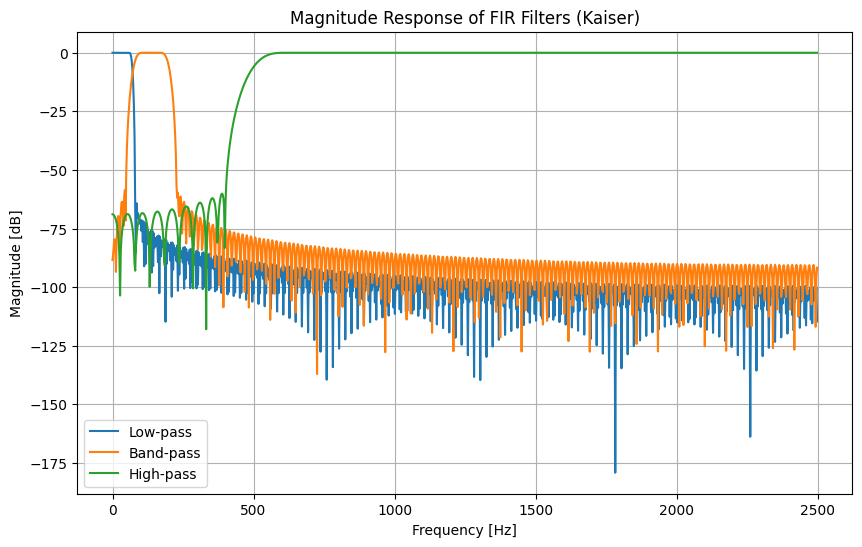

In [32]:
plt.figure(figsize=(10, 6))
plot_filter_response(b_lp, fs, "Low-pass")
plot_filter_response(b_bp, fs, "Band-pass")
plot_filter_response(b_hp, fs, "High-pass")
plt.title("Magnitude Response of FIR Filters (Kaiser)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.legend()
plt.grid()
plt.show()


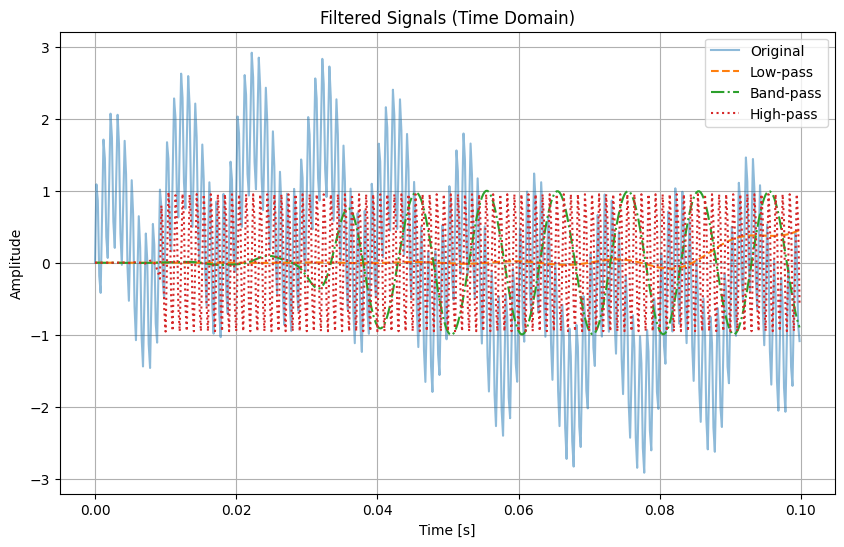

In [33]:
# Apply filters
y_lp = sg.lfilter(b_lp, 1.0, x)
y_bp = sg.lfilter(b_bp, 1.0, x)
y_hp = sg.lfilter(b_hp, 1.0, x)

# Plot time-domain comparison
plt.figure(figsize=(10, 6))
plt.plot(t[:500], x[:500], label="Original", alpha=0.5)
plt.plot(t[:500], y_lp[:500], label="Low-pass", linestyle='--')
plt.plot(t[:500], y_bp[:500], label="Band-pass", linestyle='-.')
plt.plot(t[:500], y_hp[:500], label="High-pass", linestyle=':')
plt.title("Filtered Signals (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


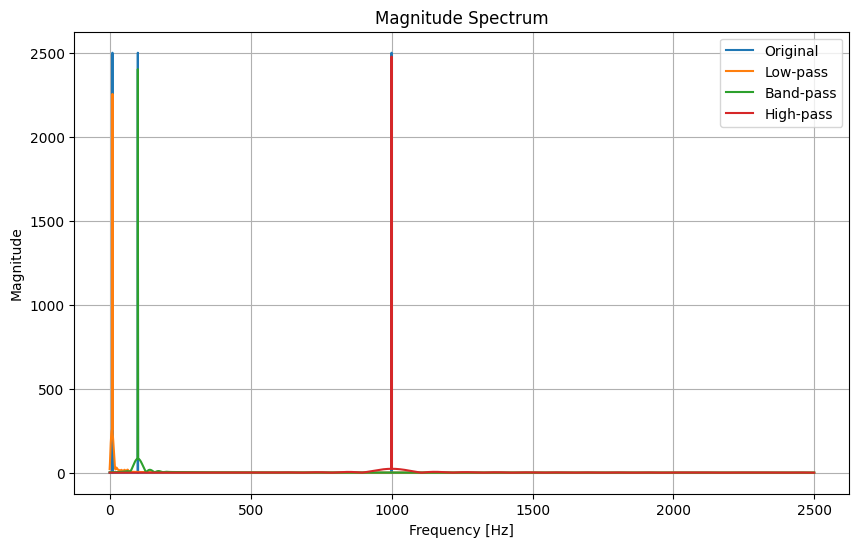

In [34]:
def plot_spectrum(signal, fs, label):
    N = len(signal)
    freq = fftfreq(N, 1/fs)[:N//2]
    magnitude = np.abs(fft(signal))[:N//2]
    plt.plot(freq, magnitude, label=label)

plt.figure(figsize=(10, 6))
plot_spectrum(x, fs, "Original")
plot_spectrum(y_lp, fs, "Low-pass")
plot_spectrum(y_bp, fs, "Band-pass")
plot_spectrum(y_hp, fs, "High-pass")
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()
